In [1]:
# Keras 
# Classifier: Merged unigram LSTM and bigram LSTM
# Classification type: multi-class (404 classes)
# Output nodes: #of classes with softmax

# word2vec model: 
# word2vect_class_specififc_bigrams__vec64_win1__dict_sample_5000

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pickle
import time

import theano
theano.config.device = 'gpu'
theano.config.floatX = 'float32'

from keras.datasets import reuters
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.wrappers import TimeDistributed
from keras.models import load_model, Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Merge
from keras.layers import Convolution1D, MaxPooling1D, Flatten
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer, one_hot, text_to_word_sequence
from keras.preprocessing import sequence

from keras.utils.visualize_util import plot
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# import custom code
import os
import sys
pardir = os.path.abspath(os.path.join(os.getcwd(), '../'))
script_path = pardir + "/2_common_aux_script"
print('Importing process_string.py \nfrom ' + script_path + " ...\n")
sys.path.append(script_path)
from process_string import process_string
sys.path.remove(script_path)


print(sys.version)

Using TensorFlow backend.


Importing process_string.py 
from /Users/altay.amanbay/Desktop/new node booster/experiments/3a.1 - Nets train/7 train model - keras (Merge unigram and bigram)/2_common_aux_script ...

3.5.2 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [2]:
# Functions

def NGramGenerator_wordwise_interval(phrase, min_ngram, max_ngram):
    all_ngram_lists = []

    #printable_ = 'abcdefghijklmnopqrstuvwxyz0123456789 '
    #s_split = "".join((char if char in printable_ else "") for char in phrase).split()
    #phrase_processed = process_string(phrase)
    #s_split = phrase_processed.split()
    s_split = phrase.split()
    
    for n in range(max_ngram, min_ngram - 1, -1):
        n_gram = [s_split[i:i+n] for i in range(len(s_split)-n+1)]
        all_ngram_lists.extend(n_gram)
        
    all_ngrams = []
    for n_gram in all_ngram_lists:
        all_ngrams.extend([' '.join(n_gram)])
    
    return all_ngrams

def get_word2index(texts_ls_):
    word2index_ = {}

    c = 1
    for text_str in texts_ls_:
        text_tokens_ls = text_str.lower().split()
        for token in text_tokens_ls:
            if(token not in word2index_):
                word2index_[token] = c
                c = c + 1
                
    return word2index_

def train_df_preprocess(top_words_, texts_ls_, max_pad_length_):
    # texts_ls_: list of texts strings
    
    tok = Tokenizer(top_words_)
    tok.fit_on_texts(texts_ls_)

    words = []
    for iter in range(top_words):
        words += [key for key,value in tok.word_index.items() if value==iter+1]

    #Class for vectorizing texts, or/and turning texts into sequences 
    #(=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i).
    texts_vec_ls = tok.texts_to_sequences(texts_ls_)#turns text to sequence, stating which word comes in what place
    texts_vec_mtx = sequence.pad_sequences(texts_vec_ls, maxlen=max_pad_length_)#pad sequence, essentially padding it with 0's at the end
    
    return texts_vec_mtx

def text_2_vec(text_str, word2index_):
    # text_str: text string
    
    text_tokens_ls = text_str.lower().split()
    
    text_vec = []
    for token in text_tokens_ls:
        if token in word2index_:
            text_vec.append(word2index_[token])
        else:
            text_vec.append(0)
            
    return text_vec

def train_df_preprocess_2(texts_ls_, word2index_, max_pad_length_):
    # texts_ls_: list of texts strings
    
    texts_vec_ls = []
    for text_ in texts_ls_:
        #print(text_)
        #print(type(text_))
        text_vec = text_2_vec(text_, word2index_)
        texts_vec_ls.append(text_vec)
    
    texts_vec_ary = sequence.pad_sequences(texts_vec_ls, maxlen=max_pad_length_)
    
    return texts_vec_ary

def texts_to_sequences_custom(texts_ls, word_index_):
    texts_seq = []
    
    for text in texts_ls:
        #text_split = text.lower().split()
        text_split = NGramGenerator_wordwise_interval(text,1,1)
        seq = []
        for token in text_split:
            if(token in word_index_):
                seq.append(word_index_[token])
            else:
                seq.append(0)
                
        texts_seq.append(seq)
#         for k,v in word_index_.items():
#             if(v == 395):
#                 print(k,v)
    return texts_seq


def get_model_file_aux(model_file_aux_name):
    with open(model_file_aux_name, 'rb') as pickle_file:
        model_file_aux = pickle.load(pickle_file)
    return model_file_aux

In [3]:
def BiGramize(phrase_):
    s = []
    phrase_processed = process_string(phrase_)
    for t in NGramGenerator_wordwise_interval(phrase_processed, 2, 2):
        s.append(t.replace(' ','_'))

    return ' '.join(s)

BiGramize('AA bb c@c Df!')

'aa_bb bb_cc cc_df'

In [4]:
# Read sampled descriptionary

path = pardir+'/1_data/'
file_name = 'sampled_descriptionary_sample_size_5000.csv'
samples_df = pd.read_csv(path + file_name)

# Rename columns
samples_df.rename(columns={'description': 'description_mod1', 
                           'category_id': 'category_id_mod1',
                           'category_path': 'category_full_path_mod1'}, inplace=True)

# Drop 'screwdrivers' from descriptionary
#samples_df = samples_df.loc[samples_df.category_id_mod1 != 927,:]

# Drop index column
samples_df.drop(labels=['index'], axis=1, inplace=True)

print('samples data shape:',samples_df.shape)
samples_df.head()

samples data shape: (956776, 3)


,description_mod1,category_id_mod1,category_full_path_mod1
0,!iT Jeans Maternity Skinny Jeans Dark Wash M,100,Apparel & Accessories > Apparel > Maternity
1,1822 Denim 'Butter' Maternity Skinny Jeans Rin...,100,Apparel & Accessories > Apparel > Maternity
2,25 J Brand Maternity Skinny Jean nirvana blue,100,Apparel & Accessories > Apparel > Maternity
3,26 J Brand Maternity Skinny Jean nirvana blue,100,Apparel & Accessories > Apparel > Maternity
4,26 James Jeans Maternity Skinny External Mater...,100,Apparel & Accessories > Apparel > Maternity


In [5]:
# Concat original train set and sampled descriptionary
#train_df = pd.concat([train_df, samples_df], axis=0)
train_df = samples_df
#train_df.reset_index(drop=True, inplace=True)

# description into chars
train_df['unigrams'] = train_df['description_mod1'].apply(lambda x: process_string(x))
train_df['bigrams']  = train_df['description_mod1'].apply(lambda x: BiGramize(x))
print('train data shape (original):',train_df.shape)

# deduplicate
train_df.drop_duplicates(subset=['unigrams'], inplace = True, keep=False)
print('train data shape (deduplicated):',train_df.shape)
    
# Encode target feature
le = LabelEncoder()
le.fit(train_df['category_full_path_mod1'])
train_df['target_le'] = le.transform(train_df['category_full_path_mod1'])


train_df.head(2)

train data shape (original): (956776, 5)
train data shape (deduplicated): (938810, 5)


,description_mod1,category_id_mod1,category_full_path_mod1,unigrams,bigrams,target_le
0,!iT Jeans Maternity Skinny Jeans Dark Wash M,100,Apparel & Accessories > Apparel > Maternity,it jeans maternity skinny jeans dark wash m,it_jeans jeans_maternity maternity_skinny skin...,27
1,1822 Denim 'Butter' Maternity Skinny Jeans Rin...,100,Apparel & Accessories > Apparel > Maternity,1822 denim butter maternity skinny jeans rinse...,1822_denim denim_butter butter_maternity mater...,27


In [6]:
# Process for unigrams
# Create train set from whole data set
# and create padded sequences
X_ls = np.array(list(train_df['unigrams']))
y_ary = np.array(list(train_df['target_le']))
y_ary_cat = np_utils.to_categorical(train_df['target_le'])

print(type(X_ls))
print(type(y_ary_cat))

#X_train_ls, X_test_ls, y_train_ary, y_test_ary = train_test_split(X_ls, y_ary_cat, test_size = 0.3)

print(len(X_ls))
print(y_ary_cat.shape)

# Convert train set into sequences for nets
top_words = None  # None: all words
max_description_length = 30

tok = Tokenizer(nb_words = top_words, filters='.')  # set filters randomly to dot, else it will remove underscores
tok.fit_on_texts(X_ls)
word_index_unigrams = tok.word_index
print('word_index size:',len(word_index_unigrams))

#train_texts_vec_ls = tok.texts_to_sequences(X_train_ls)
train_texts_vec_ls_unigrams = texts_to_sequences_custom(X_ls, word_index_unigrams)
train_texts_vec_mtx_unigrams = sequence.pad_sequences(train_texts_vec_ls_unigrams, maxlen = max_description_length)

print('train_texts_vec_mtx_unigrams shape:',train_texts_vec_mtx_unigrams.shape)
list(word_index_unigrams)[0:5]

# Delete objects
X_ls = None
y_ary = None
tok = None
train_texts_vec_ls_unigrams = None

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
938810
(938810, 398)
word_index size: 234950
train_texts_vec_mtx_unigrams shape: (938810, 30)


In [7]:
# Process for bigrams
# Create train set from whole data set
# and create padded sequences
X_ls = np.array(list(train_df['bigrams']))

print(type(X_ls))
print(len(X_ls))

# Convert train set into sequences for nets
top_words = None  # None: all words
max_description_length = 30

tok = Tokenizer(nb_words = top_words, filters='.')  # set filters randomly to dot, else it will remove underscores
tok.fit_on_texts(X_ls)
word_index_bigrams = tok.word_index
print('word_index size:',len(word_index_bigrams))

train_texts_vec_ls_bigrams = texts_to_sequences_custom(X_ls, word_index_bigrams)
train_texts_vec_mtx_bigrams = sequence.pad_sequences(train_texts_vec_ls_bigrams, maxlen = max_description_length)

print('train_texts_vec_mtx_unigrams shape:',train_texts_vec_mtx_unigrams.shape)
list(word_index_bigrams)[0:5]

# Delete objects
X_ls = None
tok = None
train_texts_vec_ls_bigrams = None

<class 'numpy.ndarray'>
938810
word_index size: 1719079
train_texts_vec_mtx_unigrams shape: (938810, 30)


In [8]:
# test check
i = 101
#print('Vec_unigrams',train_texts_vec_ls_unigrams[i])
print('Mtx_unigrams',train_texts_vec_mtx_unigrams[i])
#print('Vec_bigrams',train_texts_vec_ls_bigrams[i])
print('Mtx_bigrams',train_texts_vec_mtx_bigrams[i],'\n')

print('word_index_unigrams',len(word_index_unigrams))
print('word_index_bigrams',len(word_index_bigrams))

Mtx_unigrams [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 6813 4236  251   68   34 2297   49 2297  267]
Mtx_bigrams [      0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0   20244  445544     819      19  491051
 1183050 1683820 1709986] 

word_index_unigrams 234950
word_index_bigrams 1719079


In [9]:
## Create word embeddings from trained Word2Vec model
## for unigrams
from gensim.models import word2vec, Phrases

# Load model
file_path_1 = pardir+"/3_model_word2vec/word2vect_class_specififc_unigrams__vec64_win1__dict_sample_5000"
print(file_path_1)
model = word2vec.Word2Vec.load(file_path_1)

#print(model.vocab.keys())
#sys.exit()

# word vector embeddings from model into dictionary
word2vec_dict={}
for word in model.vocab.keys():
    try:
        word2vec_dict[word]=model[word]
    except:    
        pass
print('Loaded %s word vectors.' % len(word2vec_dict))
    
embedding_vecor_length = len(model[word])
print('embedding_vecor_length:',embedding_vecor_length)


embedding_matrix_unigrams = np.zeros((len(word_index_unigrams) + 1, embedding_vecor_length))
for word, i in word_index_unigrams.items():
    embedding_vector = word2vec_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_unigrams[i] = embedding_vector
        
print('\nembedding matrix shape:',embedding_matrix_unigrams.shape)
print(embedding_matrix_unigrams[0]) # first cell should be all zeros
print(embedding_matrix_unigrams[1])

# Delete objects
model = None
word2vec_dict = None

/Users/altay.amanbay/Desktop/new node booster/experiments/3a.1 - Nets train/7 train model - keras (Merge unigram and bigram)/3_model_word2vec/word2vect_class_specififc_unigrams__vec64_win1__dict_sample_5000
Loaded 235761 word vectors.
embedding_vecor_length: 64

embedding matrix shape: (234951, 64)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.06146404  0.081076    0.00112323  0.04499147  0.1002018   0.01332603
 -0.19582143 -0.03727768  0.08618295 -0.24972945 -0.06021989  0.28060985
  0.08473843  0.04667721  0.13200024 -0.15039206  0.00561094 -0.21778092
 -0.09161391  0.0259797  -0.11244918 -0.01754784 -0.08015888 -0.11885061
  0.13581887 -0.08760685  0.05284847  0.12670977 -0.05489041  0.32682282
 -0.00553122 -0.03708532 -0.05104759  0.01759537  0.11875682  0.13249238
 

In [10]:
## Create word embeddings from trained Word2Vec model
## for bigrams
from gensim.models import word2vec, Phrases

# Load model
file_path_1 = pardir+"/3_model_word2vec/word2vect_class_specififc_bigrams__vec64_win1__dict_sample_5000"
print(file_path_1)
model = word2vec.Word2Vec.load(file_path_1)

#print(model.vocab.keys())
#sys.exit()

# word vector embeddings from model into dictionary
word2vec_dict={}
for word in model.vocab.keys():
    try:
        word2vec_dict[word]=model[word]
    except:    
        pass
print('Loaded %s word vectors.' % len(word2vec_dict))
    
embedding_vecor_length = len(model[word])
print('embedding_vecor_length:',embedding_vecor_length)


embedding_matrix_bigrams = np.zeros((len(word_index_bigrams) + 1, embedding_vecor_length))
for word, i in word_index_bigrams.items():
    embedding_vector = word2vec_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_bigrams[i] = embedding_vector
        
print('\nembedding matrix shape:',embedding_matrix_bigrams.shape)
print(embedding_matrix_bigrams[0]) # first cell should be all zeros
print(embedding_matrix_bigrams[1])

# Delete objects
model = None
word2vec_dict = None

/Users/altay.amanbay/Desktop/new node booster/experiments/3a.1 - Nets train/7 train model - keras (Merge unigram and bigram)/3_model_word2vec/word2vect_class_specififc_bigrams__vec64_win1__dict_sample_5000
Loaded 1723576 word vectors.
embedding_vecor_length: 64

embedding matrix shape: (1719080, 64)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.00602353 -0.12864356 -0.11898886  0.19484989  0.09767632 -0.0804306
 -0.05070817 -0.09657203  0.13073626  0.1669164  -0.04072534 -0.09930911
  0.00819166  0.21398458 -0.14614362 -0.15424693  0.01904099  0.00494983
 -0.20303769  0.08396353  0.09175193  0.01089812 -0.05856525  0.13049573
  0.12205232 -0.11231349  0.16520451  0.15166625  0.0934044   0.05492248
  0.09600082  0.10321151  0.00243238  0.13833098 -0.05925417  0.08356452
 

In [11]:
# Best model result holder
best_model_aux = {}
best_model_aux['Best score'] = 0
best_model_aux['Max length'] = max_description_length
best_model_aux['texts_to_sequences'] = texts_to_sequences_custom
best_model_aux['word_index_unigrams'] = word_index_unigrams
best_model_aux['word_index_bigrams'] = word_index_bigrams
best_model_aux['Label encoder'] = le

best_model = None

In [43]:
# Optional
# Load previous model (if needs to be compared in the following training)
#best_model = load_model('category_927_nets_1000_model.h5')
#best_model_aux = get_model_file_aux('category_927_nets_1000_model_aux.pkl')

In [13]:
# prediction nodes count
nb_classes = train_df['category_full_path_mod1'].unique()
print('Classes count:', len(nb_classes))

train_df = None
samples_df = None

Classes count: 398


In [36]:
embedding_layer_unigrams = None
embedding_layer_bigrams = None
model_1_lstm = None
model_2_lstm = None
model_merge = None

In [14]:
# TRAIN MODEL 1
start = time.time()

# define/initialize model
top_words_unigrams = len(word_index_unigrams) + 1
top_words_bigrams = len(word_index_bigrams) + 1
batch_size_ = 64   # 64

## Model 1 (LSTM)
## ======================================================================================
model_1_lstm = Sequential()
## Embedding layer
embedding_layer_unigrams = Embedding(top_words_unigrams, 
                            embedding_vecor_length, 
                            weights=[embedding_matrix_unigrams], 
                            input_length = max_description_length,
                            trainable=False)
model_1_lstm.add(embedding_layer_unigrams)

## LSTM 1
LSTM_1 = LSTM(128,return_sequences=True)
model_1_lstm.add(LSTM_1)


## Model 2 (LSTM)
## ======================================================================================
model_2_lstm = Sequential()
## Embedding layer
embedding_layer_bigrams = Embedding(top_words_bigrams, 
                            embedding_vecor_length, 
                            weights=[embedding_matrix_bigrams], 
                            input_length = max_description_length,
                            trainable=False)
model_2_lstm.add(embedding_layer_bigrams)
## LSTM 1
LSTM_2 = LSTM(128,return_sequences=True)
model_2_lstm.add(LSTM_1)


## Merge models
## ======================================================================================
model_merge = Sequential()
merge_layer = Merge([model_1_lstm,model_2_lstm], mode='concat')
model_merge.add(merge_layer)
model_merge.add(LSTM(128,return_sequences=False))


## Output classes layer
## ======================================================================================
model_merge.add(Dense(len(nb_classes), activation='softmax'))
model_merge.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # try loss=categorical_crossentropy
print(model_merge.summary())

# start training multiple times with epoch=1
for ep in range(20):
    print('Epoch iter #' + str(ep+1))
    model_merge.fit([train_texts_vec_mtx_unigrams,train_texts_vec_mtx_bigrams], y_ary_cat, nb_epoch=1, batch_size=batch_size_)
    
    scores = model_merge.evaluate([train_texts_vec_mtx_unigrams,train_texts_vec_mtx_bigrams], y_ary_cat, verbose=0)
    if(best_model_aux['Best score'] < scores[1]):
        best_model_aux['Best score'] = scores[1]
        best_model = model_merge
        print('Captured improved model')
        print('Valid accuracy: ',best_model_aux['Best score'])
        #print("Accuracy on test set: %.2f%%" % (scores[1]*100))
    else:
        break
    print()
 

print("Training took %g s" % (time.time() - start))

# Accuracy: 


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 30, 64)        15036864                                     
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 30, 128)       98816                                        
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 30, 64)        110021120                                    
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 128)           197120      merge_1[0][0]                    
___________________________________________________________________________________________

In [16]:
best_model_aux['Best score']

0.98930241475910996

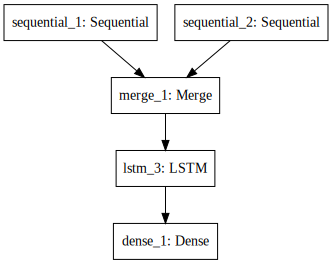

In [20]:
# Plot Nets design
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.utils.visualize_util import model_to_dot

#plot(model, to_file='/Users/altay.amanbay/Desktop/model.png')
SVG(model_to_dot(model_merge).create(prog='dot', format='svg'))


In [21]:
# Save model and aux file

best_model.save('nets_category_all__traindata5000_vectrain5000_model.h5')

best_model_aux_name = 'nets_category_all__traindata5000_vectrain5000_aux.pkl'
with open(best_model_aux_name, 'wb') as pickle_file:
    pickle.dump(best_model_aux, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

### Evaluation (optional)

In [25]:
# Final evaluation of the model
start = time.time()

scores = model.evaluate(train_texts_vec_mtx, y_train_ary, verbose=0)
print("Accuracy on train set: %.2f%%" % (scores[1]*100))
scores = model.evaluate(test_texts_vec_mtx, y_test_ary, verbose=0)
print("Accuracy on test set: %.2f%%" % (scores[1]*100))

print("\nEvaluation took %g s" % (time.time() - start))

Accuracy on train set: 86.66%
Accuracy on test set: 83.86%

Evaluation took 390.131 s


In [29]:
# Get predictions
start = time.time()

predictions = model.predict_classes(test_texts_vec_mtx)
#predictions_rnd = np.round_(predictions, decimals=0, out=None)
predictions_probs = model.predict(test_texts_vec_mtx)

print('%-20s' % "predictions[0]",':', predictions[0])
#print('%-20s' % "predictions_rnd[0]:",':',predictions_rnd[0])
#print('%-20s' % "predictions_probs[0]",':', predictions_probs[0])
print("\nPrediction took %g s" % (time.time() - start))

predictions[0]       : 10

Prediction took 0.000182152 s


In [75]:
# Manual check which nodes are not distinguishable for nets
class_ = 392
print(le.inverse_transform(class_))
print(X_test_ls[np_utils.categorical_probas_to_classes(y_test_ary)==class_],'\n')

class_ = 390
print(le.inverse_transform(class_))
print(X_test_ls[np_utils.categorical_probas_to_classes(y_test_ary)==class_],'\n')

class_ = 389
print(le.inverse_transform(class_))
print(X_test_ls[np_utils.categorical_probas_to_classes(y_test_ary)==class_],'\n')


Tools & Home Improvement > Lighting, Light Bulbs & Ceiling Fans > Other
[ 'progress lighting p299281 archiethree light bath vanity antique nickel finish'
 'bulbrite 60a15f 60watt incandescent a15 appliance bulb frost'
 'greenhouse indooroutdoor chandelier rasped iron finish' ...,
 'ge advantage fluorescent'
 'feit ctcdm500led 60w equivalent candelabra base torpedo tip chandelier led light soft white'
 'alena 97 arched floor lamp by house of hampton'] 

Tools & Home Improvement > Lighting, Light Bulbs & Ceiling Fans > Light Fixtures & Lamps
['cortina nightstand right door'
 'camino vintage candelabra twotier chandelier 72'
 'golden lighting 2501ba3' ..., 'aspect white 23 open unit'
 'harpwell 7light oilrubbed bronze chandelier'
 'connie 2light antique black flush mount'] 

Tools & Home Improvement > Lighting, Light Bulbs & Ceiling Fans > Light Bulbs
[ '3 pack led light bulbs lohas b35 7w soft white 3000k e12 candelabra bulb equivalent to 6065 watt incandescent'
 'br30 led bulbsluminwiz 

In [61]:
#pd.crosstab(pd.Series(y_test_ary.ravel()), pd.Series(predictions_rnd.ravel()), rownames=['True'], colnames=['Predicted'], margins=True)
pd.crosstab(pd.Series(np_utils.categorical_probas_to_classes(y_test_ary)), pd.Series(predictions), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,5,6,9,10,11,12,...,389,390,392,393,394,395,396,397,403,All
True,,,,,,,,,,,,,,,,,,,,,
1,107,0,24,4,4,0,5,1,0,0,...,0,0,0,0,0,0,0,0,0,160
2,7,12,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
3,21,1,1126,120,148,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,1490
4,3,3,275,826,254,0,0,12,0,0,...,0,0,0,0,0,0,0,0,0,1424
5,5,1,104,84,1242,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,1508
6,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
9,0,0,0,0,0,0,304,49,2,0,...,0,0,0,0,0,0,0,0,0,361
10,0,0,8,1,1,0,41,1320,62,0,...,0,0,1,0,0,0,0,0,0,1464
11,0,0,0,0,0,0,2,202,405,0,...,0,0,0,0,0,0,0,0,0,618


In [58]:
pd.crosstab(pd.Series(np_utils.categorical_probas_to_classes(y_test_ary)), pd.Series(predictions.ravel()), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,78363,103,78466
1,102,1493,1595
All,78465,1596,80061


### Testing

In [102]:
#model.get_config()
def prediction_to_str(clf_prediction, category_id):
    if(clf_prediction > 0.5):
        return str(category_id)
    else:
        return 'not ' + str(category_id)

def predict(description_str, tok_, clf_, max_length_, category_id_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str.lower()], tok_.word_index)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    clf_prediction = clf_.predict(seq_pad)
    
    #print(seq_)
    #print(seq_pad)
    
    # Prediction to string
    clf_prediction_str = prediction_to_str(clf_prediction[0][0], category_id_)
    
    return clf_prediction_str
    #return clf_prediction[0][0]

def predict_2(description_str, tok_, clf_, max_length_, category_id_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str.lower()], tok_.word_index)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    #clf_prediction = clf_.predict(seq_pad)
    clf_prediction = model.predict_classes(seq_pad)
    
    #print(seq_)
    #print(seq_pad)
    
    # Prediction to string
    #clf_prediction_str = prediction_to_str(clf_prediction[0][0], category_id_)
    clf_prediction = le.inverse_transform(clf_prediction)
    
    if(clf_prediction == ['Positive']):
        return str(category_id_)
    else:
        return 'not ' + str(category_id_)
    
    
def predict_proba(description_str, tok_, clf_, max_length_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str], tok_.word_index)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    clf_prediction_proba = clf_.predict_proba(seq_pad, verbose=0)
    
    return clf_prediction_proba[0][0]


# id_ = 'table Setr'
# p = predict(id_, best_model_aux['Tokenizer'], best_model, best_model_aux['Max length'], best_model_aux['Category ID'])
# pp = predict_proba(id_, best_model_aux['Tokenizer'], best_model, best_model_aux['Max length'])
# print(p)
# print(pp)

In [103]:
# TEST

## load old model
model_file = "category_927_nets__traindata5000_vectrain5000_model.h5"
aux_file = "category_927_nets__traindata5000_vectrain5000_aux.pkl"
old_best_model_ = load_model(model_file)
old_best_model_aux_ = get_model_file_aux(aux_file)
old_tok_ = old_best_model_aux_['Tokenizer']
old_word_index_ = old_best_model_aux_['Tokenizer'].word_index

## use fresh model
best_model_ = best_model
best_model_aux_ = best_model_aux
tok_ = tok
word_index_ = word_index

item_d = 'NieR: Automata™ DEMO 120161128 (Playable Demo)'

# screwdrivers check
scrw_items = [
"tekton 2655 flare nut wrench set metric 6piece"
,"tekton 2780 10slot screwdriver holder and organizer"
,"titan 17237 insulated electrical screwdriver set  7 piece"
,"tool sorter screwdriver organizer red"
,"torin sdh15rt magnetic screwdriver holder"  #wrong predict
,"wera 05020013001 joker combination wrenchset 11 pieces"
,"wera kk vde 60i62i68i18 insulated pouch set with interchangeable blades 18piece" # tricky
,"wiha 28103 magnetic 14 bit holder stubby 57mm pliers screwdriver" # tricky, wrong predict
]

for n, i in enumerate(scrw_items):
    item_d = i
    
    print(str(n) + ' ' + '='*100)
    
    print('Old model prediction:')
    print('item:',item_d)
    print('Seq max len:', old_best_model_aux_['Max length'])
    print(predict(item_d, old_tok_, old_best_model_, old_best_model_aux_['Max length'], '927'))
    print(predict_proba(item_d, old_tok_, old_best_model_, old_best_model_aux_['Max length']))


    print('\nFresh model prediction:')
    print('item:',item_d)
    print('Seq max len:', best_model_aux_['Max length'])
    print(predict_2(item_d, tok_, best_model_, best_model_aux_['Max length'], '927'))
    #print(predict_proba(item_d, tok_, best_model_, best_model_aux_['Max length']))

    print()

    #tt = train_df.loc[0:10,['description_mod1']]
    #tt['pred'] = tt['description_mod1'].apply(lambda x: predict(x, best_model_aux_['Tokenizer'], best_model, best_model_aux_['Max length'], best_model_aux_['Category ID']))
    #tt['prob'] = tt['description_mod1'].apply(lambda x: predict_proba(x, best_model_aux_['Tokenizer'], best_model, best_model_aux_['Max length']))

0 ====================================================================================================
Old model prediction:
item: tekton 2655 flare nut wrench set metric 6piece
Seq max len: 30
not 927
4.17323e-08

Fresh model prediction:
item: tekton 2655 flare nut wrench set metric 6piece
Seq max len: 30
1/1 [==============================] - 0s
not 927

1 ====================================================================================================
Old model prediction:
item: tekton 2780 10slot screwdriver holder and organizer
Seq max len: 30
not 927
0.121584

Fresh model prediction:
item: tekton 2780 10slot screwdriver holder and organizer
Seq max len: 30
1/1 [==============================] - 0s
927

2 ====================================================================================================
Old model prediction:
item: titan 17237 insulated electrical screwdriver set  7 piece
Seq max len: 30
927
0.998989

Fresh model prediction:
item: titan 17237 insulated electric